# Neural Networks II
G. Richards
(2016, 2018, 2020, 2022)
[Ivezic 9.8](https://www.astroml.org/book_figures/chapter9/index.html) and [Geron](https://www.amazon.com/Hands-Machine-Learning-Scikit-Learn-TensorFlow/dp/1492032646/ref=sr_1_5?dchild=1&keywords=machine+learning&qid=1596499152&sr=8-5).   With updates to my own class from [Stephen Taylor's class at Vanderbilt](https://github.com/VanderbiltAstronomy/astr_8070_s22).


## Contents
* [Preliminaries](#one)
* [Example: Photo-z With Torch](#two)
* [Example: Fashion MNIST with Keras](#three)
* [Convolutional Neural Networks (CNNs)](#four)
* [Autoencoders](#five)
* [Generative Adversarial Networks (GANs)](#six)

## Preliminaries <a class="anchor" id="one"></a>

Before starting today, let's install some software, including the two big Deep Learning packages out there. [Tensorflow](https://www.tensorflow.org/) and [PyTorch](https://pytorch.org/)-- the rivalry essentially boils down to Google versus Facebook.  See the cells below.  Go ahead and do this while you are waiting for lecture to start.

While you are waiting for software to install, please go to https://playground.tensorflow.org/

Try the default. Note how the first layer identifies simple patterns and the second layer combines those to make more complex patterns. It also finds a solution quite quickly. (Note also that it won't stop on its own. Hit pause when you are happy with the solution it has converged on.)
Try a ReLU activation function. Much faster, but with a "boxy" solution.
See what happens when there is only 1 hidden layer with 3 neurons. Reset and run it multiple times.
Compare learning rate 0.001 to 1.0.
Now try just 2 neurons (with learning rate back at 0.3).
Now try 8 neurons.
Lastly try the spiral dataset with 4 hidden layers, each with 8 neurons. Run it for at least 1000-1500 epochs -- until it gets the answer "right" (make sure that your computer is plugged in and properly cooled!) This illustrates the vanishing gradient problem.
Do this again after lecture.

See Problem 10.1 in Geron

In [1]:
from matplotlib import pyplot as plt
import numpy as np

In [2]:
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)
print(keras.__version__)

2.10.0
2.10.0


In [ ]:
import tensorflow as tf

---

### Keras

**[Keras](https://keras.io/)** is a **deep learning** API. Essentially it is Scikit-Learn for deep neural networks.

Keras needs a computational backend to handle the heavy computation.  Three popular (open sources) deep learning libraries are [TensorFlow](https://www.tensorflow.org/), Microsoft Cognitive Toolkit, and [Theano](http://www.deeplearning.net/software/theano/). TensorFlow now comes bundled with a version of Keras and that's what we'll use here (actually TensorFlow 2). PyTorch is another option.  Section 9.8 of Ivezic includes examples using both `keras` and `torch`.

If you apply for a data-science job in industry, knowing one of these tools might be the most useful thing for you to have learned.

In short, for neural networks:

> numpy -> tensorflow

> sklearn -> keras

In the same way that you can build a linear regression algorithm in numpy without using sklearn, you can build a neural network algorithm (not to mention linear regression) in tensorflow without using keras.  But just as sklearn makes our life easier, so too does keras.  


Keras has Sequential and Functional APIs.  We will just use Sequential in our examples.

Just as I'm teaching you about sklearn and not numpy, I have no intention of teaching you tensorflow.  I'm also not going to teach you pytorch, but here is an example using it.

## Example: Photo-z with Torch <a class="anchor" id="one"></a>

An important problem in galaxy imaging is being able to use observed galaxy color data to estimate its redshift. This is sometimes called "photo-z". Now, on your humble computer, you will build a deep neural network that is trained on a sample of SDSS galaxy color data. You'll see that `pytorch` makes this quite easy.

In [4]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as torchdata

from astroML.datasets import fetch_sdss_specgals
from astroML.utils.decorators import pickle_results

from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

AttributeError: module 'numpy.distutils.__config__' has no attribute 'blas_opt_info'

Read in and prepare the SDSS data.

In [5]:
# Fetch and prepare the data
data = fetch_sdss_specgals()

# put magnitudes into array
# normalize to zero mean and unit variance for easier training
datanormed = np.zeros((len(data), 6), 
                      dtype=np.float32)

for i, band in enumerate(['u', 'g', 'r', 'i', 'z']):
    band = 'modelMag_' + band
    datanormed[:, i] = ((data[band] - data[band].mean()) / 
                        data[band].std())

# put redshifts into array
datanormed[:, 5] = data['z']

Let's define a little helper class that will make our network. It is initialized with a given number of neurons in the single hidden layer. These neurons in the hidden layer connect to $5$ input variables (colors) and spits out 1 variable (redshift). You can also see that it uses ReLU activation for the neurons.

In [6]:
# define structure of neural net
class Net(nn.Module):
    def __init__(self, nhidden):
        super(Net, self).__init__()
        self.fc_h = nn.Linear(5, nhidden)
        self.fc_o = nn.Linear(nhidden, 1)

    def forward(self, x):
        h = F.relu(self.fc_h(x))
        z = self.fc_o(h)
        return z

Do a train-test split on the data.

In [7]:
# split data into 9:1 train:test
dataset = torchdata.TensorDataset(torch.tensor(datanormed[:, 0:5]),
                                  torch.tensor(datanormed[:, 5]).view(-1, 1))
trainnum = datanormed.shape[0] // 10 * 9
traindata, testdata = torchdata.random_split(dataset, 
                                             [trainnum, datanormed.shape[0] - trainnum])
traindataloader = torchdata.DataLoader(traindata, 
                                       batch_size=128, 
                                       shuffle=True)

Define a function to train the neural network. This looks like a lot of code, but the first block is the key. The network will have $4$ neurons in the hidden layer, and will use stochastic gradient descent to train the weights and biases.

In [8]:
@pickle_results('NNphotoz.pkl')
def train_NN():
    # 4 hidden layers
    model = Net(4)
    # MSE loss
    criterion = torch.nn.MSELoss(reduction='sum') 
    # stochastic gradient descent
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001) 
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                           verbose=True, 
                                                           patience=5, 
                                                           threshold=1e-3)

    min_valid_loss = float('inf')
    badepochs = 0
    for t in range(100):
        train_loss = 0
        for i, databatch in enumerate(traindataloader, 0):
            photometry, redshifts = databatch
            optimizer.zero_grad()
            z_pred = model(photometry)
            loss = criterion(z_pred, redshifts)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        with torch.no_grad():
            photometry = testdata[:][0]
            redshifts = testdata[:][1]
            z_pred = model(photometry)
            valid_loss = criterion(z_pred, redshifts)
            if t % 10 == 0:
                print('Epoch %3i: train loss %0.3e validation loss %0.3e' % (t, \
                        train_loss / len(traindata), valid_loss / len(testdata)))
            # stop training if validation loss has not fallen in 10 epochs
            if valid_loss > min_valid_loss*(1-1e-3):
                badepochs += 1
            else:
                min_valid_loss = valid_loss
                badepochs = 0
            if badepochs == 10:
                print('Finished training')
                break
        scheduler.step(valid_loss)
    return model

Let's train this thing. It should take about five minutes. 

In [9]:
model = train_NN()

@pickle_results: computing results and saving to 'NNphotoz.pkl'
Epoch   0: train loss 1.541e-03 validation loss 1.282e-03
Epoch  10: train loss 8.816e-04 validation loss 8.671e-04
Epoch  20: train loss 8.328e-04 validation loss 8.283e-04
Epoch  30: train loss 6.695e-04 validation loss 6.882e-04
Epoch  40: train loss 6.366e-04 validation loss 6.503e-04
Epoch  50: train loss 6.129e-04 validation loss 6.190e-04
Epoch  60: train loss 6.038e-04 validation loss 6.013e-04
Epoch  70: train loss 5.969e-04 validation loss 5.971e-04
Epoch  80: train loss 5.872e-04 validation loss 5.826e-04
Epoch  90: train loss 5.784e-04 validation loss 5.707e-04


In [10]:
print(model)

Net(
  (fc_h): Linear(in_features=5, out_features=4, bias=True)
  (fc_o): Linear(in_features=4, out_features=1, bias=True)
)


Plot the results.

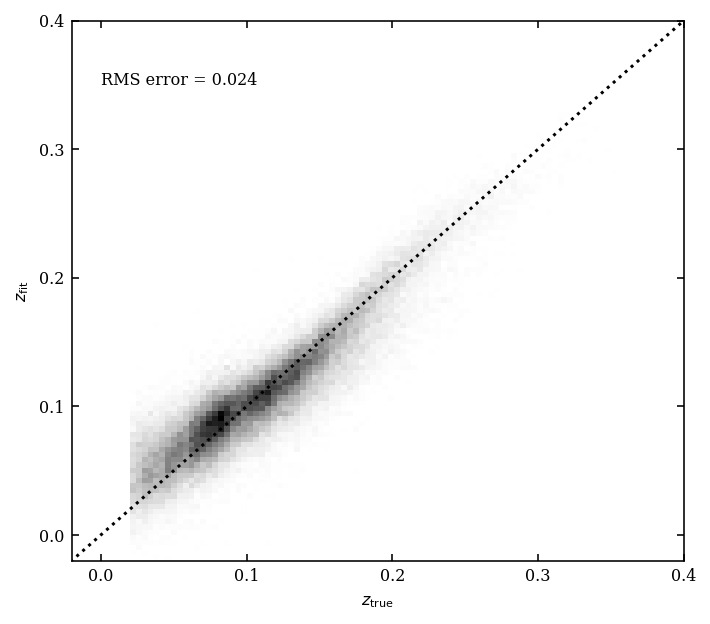

In [11]:
# plot the results
with torch.no_grad():
    photometry = testdata[:][0]
    redshifts = testdata[:][1]
    z_pred = model(photometry)
    fig = plt.figure(figsize=(5, 5))
    fig.subplots_adjust(wspace=0.25,
                        left=0.1, right=0.95,
                        bottom=0.15, top=0.9)

    ax = plt.axes()
    H, zs_bins, zp_bins = np.histogram2d(redshifts.numpy().flatten(), 
                                         z_pred.numpy().flatten(), 151)
    ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto',
               extent=[zs_bins[0], zs_bins[-1], zp_bins[0], zp_bins[-1]],
               cmap=plt.cm.binary)
    ax.plot([-0.1, 0.4], [-0.1, 0.4], ':k')
    rms = np.sqrt(np.mean((z_pred-redshifts).numpy()**2))
    
    ax.text(0, 0.35, 'RMS error = %0.3f' % np.sqrt(np.mean((z_pred-
                                                            redshifts).numpy()**2)))
    ax.set_xlim(-0.02, 0.4001)
    ax.set_ylim(-0.02, 0.4001)
    ax.xaxis.set_major_locator(plt.MultipleLocator(0.1))
    ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))
    
    ax.set_xlabel(r'$z_{\rm true}$')
    ax.set_ylabel(r'$z_{\rm fit}$')
    
    plt.show()

Not bad. Still, this was a relatively simple fully-connected network. Other problems will require more complexity...

## Example: Fashion MNIST with Keras

The following cells are from Geron, Chapter 10, see 
https://github.com/ageron/handson-ml2/blob/master/10_neural_nets_with_keras.ipynb

I'll indicate below when I switch chapters.

We'll start by introducing the Fashion MNIST data set, which is as common for learning about neural networks as the MNIST are for machine learning in general.  We can also use the MNIST data too.

The next cells load the data, define test, trainging, and validation sets; normalize the data; display an example image; list the possible target values ($y$), and show a 4x10 grid of examples.

In [16]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

print(X_train_full.shape)
print(X_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [17]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(55000, 28, 28)
(5000, 28, 28)
(10000, 28, 28)


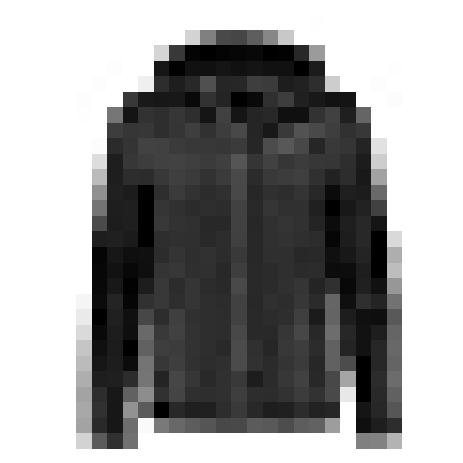

In [7]:
plt.imshow(X_train[0], cmap="binary", origin='upper') #Origin controls right-side up
plt.axis('off')
plt.show()

Take a look at some of the other entries in the training data.  Also see what happens when you remove the `origin='upper'` parameter.

In [18]:
#Let's make a list of class names that we can refer to.
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

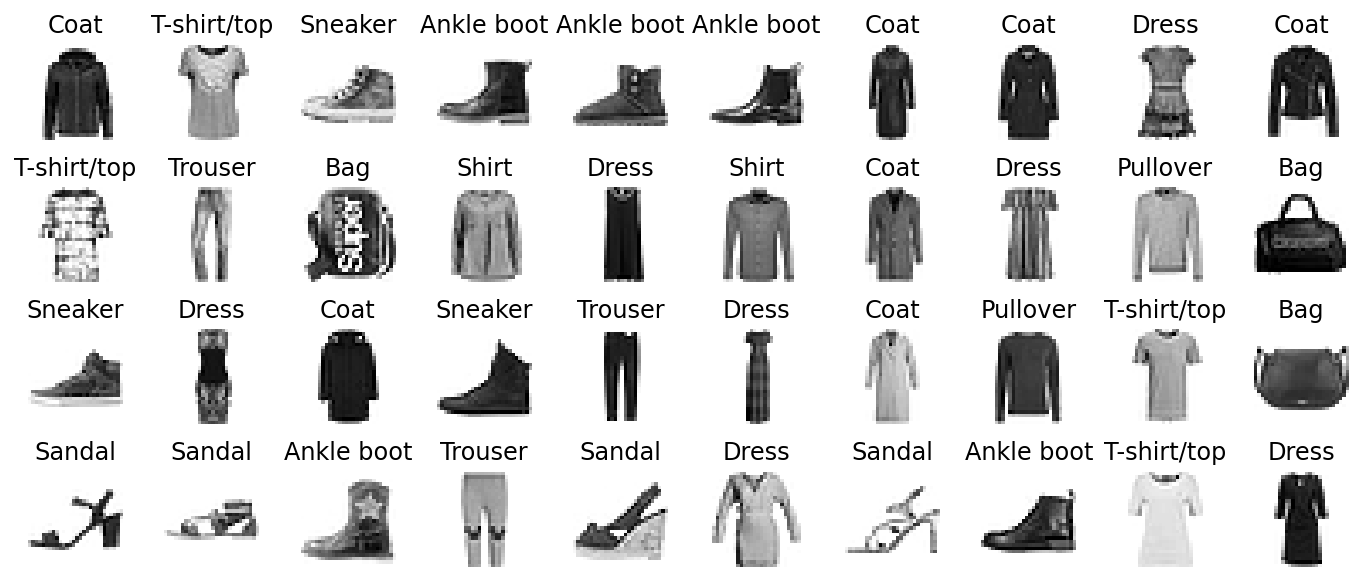

In [19]:
# Plot 4x10 array of images from the Fashion MNIST database
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest", origin='upper')
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

Now we'll build a "simple" neural network that classifies an unknown image (preprocessed to have the same image and color scale) into one of these 10 categories.

In [26]:
keras.backend.clear_session() #Make sure that we are starting a new model and not adding to an earlier one
np.random.seed(42) #Set the numpy and tensorflow random seeds so that we all get the same answer
tf.random.set_seed(42)

In [27]:
model = keras.models.Sequential() #Instantiate a sequential model
model.add(keras.layers.Flatten(input_shape=[28, 28])) #Define the input layer
model.add(keras.layers.Dense(300, activation="relu")) #First hidden layer
model.add(keras.layers.Dense(100, activation="relu")) #Second hidden layer
model.add(keras.layers.Dense(10, activation="softmax")) #Output layer

Need to define the input size/shape for the first layer.  The others know how to talk to each other.  The last layer sets the number of outputs.  Need softmax here because there are 10 categories.  If just one output or two, then a different activation function would be used.

In [28]:
#Let's see what we just built
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


The number of parameters in each layer is one for each weight that connects each node of the layer to the previous layer, plus the number of neurons in the layer to account for the constant "bias" parameter (e.g., 784x300+300 = 235500).

Note that "Dense" here means "fully connected".  That is, each node in one layer is connected to each node in the next layer.  This does't always have to be the case.  The layers can instead be "Sparse".

We can access (or set) the weights with `get_weights()` and `set_weights()` as follows.  Note that the initial weights are set randomly and the bias values are initially zero.

In [29]:
hidden1 = model.layers[1]
weights, biases = hidden1.get_weights()
#Weights set to random numbers to break degeneracy
#Biases are set to 0
print(weights.shape,weights,biases)

(784, 300) [[-0.02721255 -0.01426459 -0.02269894 ... -0.04440844 -0.06835337
  -0.02006648]
 [ 0.02066797 -0.00869863  0.07431422 ...  0.01602936 -0.03880849
  -0.02294054]
 [-0.00773063 -0.07120966  0.01091816 ... -0.04607778  0.04314004
  -0.0535525 ]
 ...
 [-0.00678801 -0.06329725 -0.03649122 ...  0.07011899 -0.04288867
  -0.03928087]
 [-0.01923557 -0.06725887 -0.03835572 ...  0.05189626  0.05669649
  -0.01617726]
 [ 0.00952394 -0.00280913 -0.00234949 ...  0.06334069 -0.03048073
  -0.05739789]] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

For neural networks we can't just fit the model after we instantiate it.  We need to compile first--specifying the loss function, the optimizer, and any desired metrics.

In [30]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

Now we can go ahead and fit the model with our training data.  The fit method will output a bunch of useful diagnostics that we'll save to `history` for plotting later.

In [31]:
history = model.fit(X_train, y_train, epochs=50,
                    validation_data=(X_valid, y_valid))

Epoch 1/50
  10/1719 [..............................] - ETA: 10s - loss: 2.2224 - accuracy: 0.1750 

2022-11-16 10:44:08.871832: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1719/1719 [==============================] - ETA: 0s - loss: 0.7259 - accuracy: 0.7623

2022-11-16 10:44:18.680055: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1719/1719 [==============================] - 11s 6ms/step - loss: 0.7259 - accuracy: 0.7623 - val_loss: 0.5163 - val_accuracy: 0.8240
Epoch 2/50
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4883 - accuracy: 0.8288 - val_loss: 0.4363 - val_accuracy: 0.8540
Epoch 3/50
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4429 - accuracy: 0.8438 - val_loss: 0.5178 - val_accuracy: 0.8042
Epoch 4/50
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4169 - accuracy: 0.8538 - val_loss: 0.3972 - val_accuracy: 0.8656
Epoch 5/50
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3989 - accuracy: 0.8595 - val_loss: 0.3786 - val_accuracy: 0.8722
Epoch 6/50
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3803 - accuracy: 0.8664 - val_loss: 0.3757 - val_accuracy: 0.8728
Epoch 7/50
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3679 - accuracy: 0.8701 - val_loss: 0.3666 - val_accuracy: 0.8

Comment on what is happening with loss, val_loss, and accuracy.

Our metrics of interest were printed at each epoch (each pass through the neural network to update the weights), but it is easier to just look at a plot!

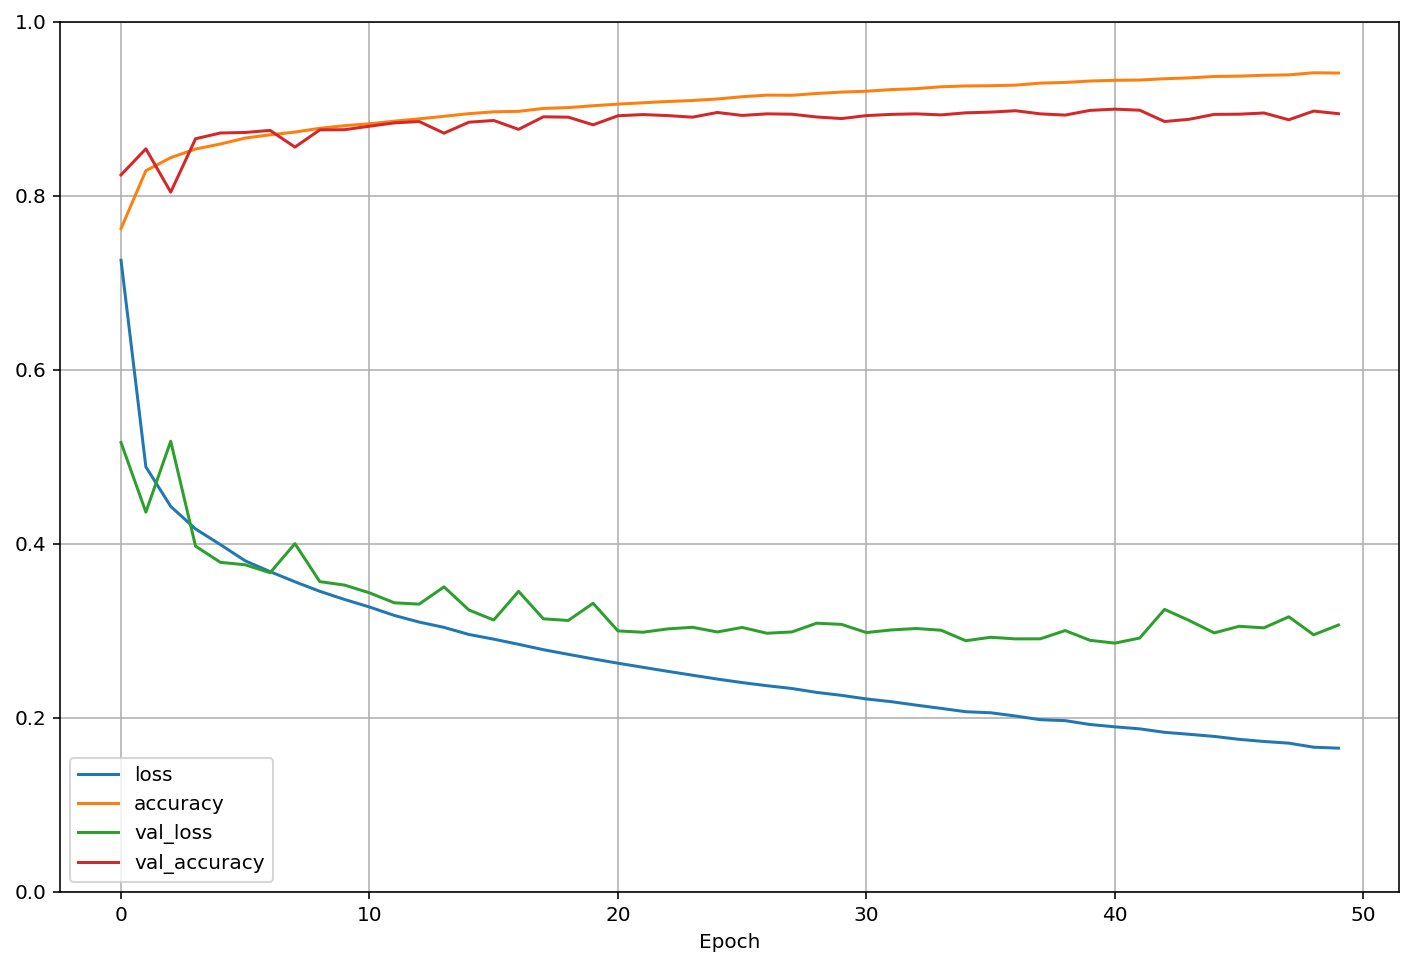

In [32]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(12, 8))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.gca().set_xlabel("Epoch")
plt.show()

As was the case for model training before, we want to make sure that we aren't overtraining, which would be indicated by the training loss diverging from the validation loss.  Note that, instead of creating a specific validation set, we can also pass `validation_split=0.1` as a parameter during the fitting step to split off 10% of the data for validation.

Now we will `evaluate` the model using the test set to determine the expected level of error on unknown data.    The usual `predict` method then can be used to make predictions.  [GTR: I'm not sure the reason for this structure.  In regular ML we would `predict` on the test set and the compute metrics with the output values.]

In [14]:
#Evaluate the test set
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 790us/step - loss: 0.3304 - accuracy: 0.8820


[0.33043035864830017, 0.8820000290870667]

In [15]:
#Predict values for first 3 test objects
X_new = X_test[:3]
y_proba = model.predict(X_new).round(2)
print(y_proba)

[[0.   0.   0.   0.   0.   0.02 0.   0.02 0.   0.95]
 [0.   0.   0.99 0.   0.01 0.   0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.   0.   0.   0.  ]]


So, you can see that the output is a probability that the object belongs to each class (which has to sum to 1 across all the classes).  If we just want an "answer", we assign it to the class with the highest probability (done here with `predict_classes`).

In [16]:
#y_pred = model.predict_classes(X_new) #Old way
y_pred = np.argmax(model.predict(X_new), axis=-1) #New way
print(y_pred)
print(np.array(class_names)[y_pred])

[9 2 1]
['Ankle boot' 'Pullover' 'Trouser']


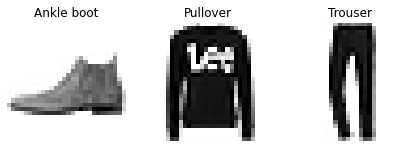

In [17]:
#Let's plot those and see if the predictions make sense.
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest", origin='upper')
    plt.axis('off')
    plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
#save_fig('fashion_mnist_images_plot', tight_layout=False)
plt.show()

Note that after you fit your model, you can save it and reload it at some later time (which is good because some models might take hours to train!)

In [18]:
#Save model
model.save("my_keras_model.h5")

#Reload model
model = keras.models.load_model("my_keras_model.h5")

Let's predict the values for 10 random objects.  Display them with their actual labels first, then predict and display the predictions.

In [19]:
idx10 = np.random.choice(np.arange(len(y_test)), size=10, replace=False)
X_new = X_test[idx10]
#y_pred = model.predict_classes(X_new)
y_pred = np.argmax(model.predict(X_new), axis=-1)

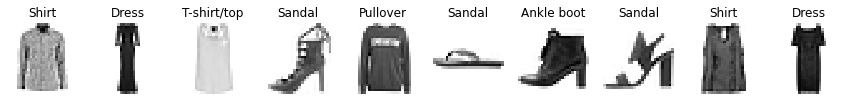

In [20]:
#Correct answers (y_test)
plt.figure(figsize=(15, 5))
for index, image in enumerate(X_new):
    plt.subplot(1, 10, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest", origin='upper')
    plt.axis('off')
    plt.title(class_names[y_test[idx10[index]]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

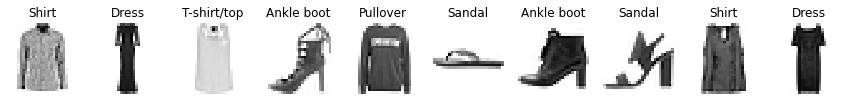

In [21]:
#Predicted answers (y_pred)
plt.figure(figsize=(15, 5))
for index, image in enumerate(X_new):
    plt.subplot(1, 10, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest", origin='upper')
    plt.axis('off')
    plt.title(class_names[y_pred[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

---

Here's a regression example instead of classification

In [22]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

print(X_train.shape)
print(y_train.shape)

(11610, 8)
(11610,)


In [23]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(lr=1e-3))

history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

mse_test = model.evaluate(X_test, y_test)

X_new = X_test[:3]
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 0s 840us/step - loss: 1.6419 - val_loss: 0.8560
Epoch 2/20
363/363 [==============================] - 0s 642us/step - loss: 0.7047 - val_loss: 0.6531
Epoch 3/20
363/363 [==============================] - 0s 646us/step - loss: 0.6345 - val_loss: 0.6099
Epoch 4/20
363/363 [==============================] - 0s 648us/step - loss: 0.5977 - val_loss: 0.5658
Epoch 5/20
363/363 [==============================] - 0s 664us/step - loss: 0.5706 - val_loss: 0.5355
Epoch 6/20
363/363 [==============================] - 0s 648us/step - loss: 0.5472 - val_loss: 0.5173
Epoch 7/20
363/363 [==============================] - 0s 654us/step - loss: 0.5288 - val_loss: 0.5081
Epoch 8/20
363/363 [==============================] - 0s 648us/step - loss: 0.5130 - val_loss: 0.4799
Epoch 9/20
363/363 [==============================] - 0s 654us/step - loss: 0.4992 - val_loss: 0.4690
Epoch 10/20
363/363 [==============================] - 0s 642us/step - loss: 0.487

In [27]:
#Back to the fashion MNIST data
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

In [28]:
#Dropout example
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.2), #20% chance of neuron stuck in off position
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid))

Epoch 1/2
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5850 - accuracy: 0.7881 - val_loss: 0.4390 - val_accuracy: 0.8434
Epoch 2/2
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4525 - accuracy: 0.8331 - val_loss: 0.3564 - val_accuracy: 0.8656


---

Just as it is often necessary to normalize or standardize our features, sometimes it is helpful to do the same to the output of the hidden layers.  This is called [batch normalization](https://en.wikipedia.org/wiki/Batch_normalization) and is done before passing the data to the activation function.  It make the process more stable and can also make it faster. 

Here's an example using batch normalization.

[GTR: Not sure where to put this.]

In [29]:

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

In [30]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 784)               3136      
_________________________________________________________________
dense_11 (Dense)             (None, 300)               235500    
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
dense_12 (Dense)             (None, 100)               30100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_13 (Dense)             (None, 10)               

In some cases you might want to do the batch normalization before applying the activation function.  Here we also turn off the bias parameter because it ends up not being needed and just wastes a parameter.

In [31]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(100, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [32]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [33]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 1.0388 - accuracy: 0.6720 - val_loss: 0.6612 - val_accuracy: 0.7948
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6702 - accuracy: 0.7824 - val_loss: 0.5460 - val_accuracy: 0.8202
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5909 - accuracy: 0.8025 - val_loss: 0.4944 - val_accuracy: 0.8368
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5411 - accuracy: 0.8168 - val_loss: 0.4631 - val_accuracy: 0.8472
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5103 - accuracy: 0.8259 - val_loss: 0.4415 - val_accuracy: 0.8532
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4886 - accuracy: 0.8323 - val_loss: 0.4235 - val_accuracy: 0.8570
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4719 - accuracy: 0.8383 - val_loss: 0.4106 - val_accuracy:

---

Now let's use cross validation to determine the best options.  Here we have so many that we'll use [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) instead of `GridSearchCV`.

First we need to do some preprocessing to get sklearn and keras to talk nicely to each other.

Start by building the model in a way that the hyperparameters are themselves parameters, then wrap that model in a way that we can use it within sklearn.

See
https://github.com/ageron/handson-ml2/blob/master/10_neural_nets_with_keras.ipynb

In [34]:
def build_model(n_hidden=1, n_neurons=10, learning_rate=3e-3, input_shape=[28,28]):
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=input_shape))
    for layer in range(n_hidden): #Because the number of hidden layers is a parameter
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(10, activation="softmax")) #Output layer
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model

In [35]:
keras_class = keras.wrappers.scikit_learn.KerasClassifier(build_model)
#Note that there is also a KerasRegressor for regression problems.

`keras_class` can now be used with in sklearn in the same way as any other classifier.  For example:

In [40]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    #"n_hidden": [0, 1, 2, 3],
    "n_hidden": (0, 1),
    #"n_neurons": np.arange(1, 30), #This would take too long for class!
    "n_neurons": (5,10),
    #"learning_rate": reciprocal(3e-4, 3e-2) #Not quite sure what this does, but it makes it take forever!
}

rnd_search_cv = RandomizedSearchCV(keras_class, param_distribs, n_iter=10, cv=3, verbose=2)

We'll try this on the MNIST digits data.

In [41]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.
X_new = X_test[:10]
y_new = y_test[:10]

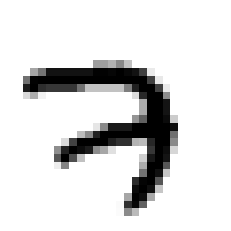

In [42]:
plt.imshow(X_train[0], cmap="binary", origin="upper")
plt.axis('off')
plt.show()

Note that we are doing 3-fold cross validation, so the validation set isn't being used for training, just for early stopping.

In [47]:
print(rnd_search_cv.best_params_)
print(rnd_search_cv.cv_results_)

{'n_neurons': 10, 'n_hidden': 1}
{'mean_fit_time': array([71.09016434, 71.00791462, 72.86207604, 73.09607641]), 'std_fit_time': array([0.62145127, 0.70233031, 0.51245304, 0.65731931]), 'mean_score_time': array([0.727331  , 0.57393201, 0.58239969, 0.58222636]), 'std_score_time': array([0.20061311, 0.00899868, 0.01033874, 0.00338686]), 'param_n_neurons': masked_array(data=[5, 10, 5, 10],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'param_n_hidden': masked_array(data=[0, 0, 1, 1],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'n_neurons': 5, 'n_hidden': 0}, {'n_neurons': 10, 'n_hidden': 0}, {'n_neurons': 5, 'n_hidden': 1}, {'n_neurons': 10, 'n_hidden': 1}], 'split0_test_score': array([0.91262138, 0.91251224, 0.89091307, 0.92243916]), 'split1_test_score': array([0.90879834, 0.90956199, 0.88027054, 0.916053  ]), 'split2_test_score': array([0.9147439 , 0.91512573, 0.89145255,

In [49]:
[m for m in dir(keras.layers) if "relu" in m.lower()]

['LeakyReLU', 'PReLU', 'ReLU', 'ThresholdedReLU']

---

## Convolutional Neural Networks (CNNs) <a class="anchor" id="four"></a>

Recent interest in neural networks surged in 2012 when a team using a deep [convolutional neural network (CNN)](https://en.wikipedia.org/wiki/Convolutional_neural_network) acheived record results classifying objects in the [ImageNet](http://image-net.org/) data set.

The idea behind CNNs is inspired by human visual perception.  Each neuron in your visual cortex doesn't "see" all of what your eye can see at once and some neuron are more sensitive to one pattern over another (e.g., horizontal lines vs. vertical lines).  

Moreover, the simplest deeply connected neural networks would choke on "real" data which has far more than 28x28 pixels and would require following tens of millions of connections.  So we use a combination of **convolution** and **pooling** to reduce the dimensionality of the data first.

![Ivezic Figure 9.19](https://www.astroml.org/_images/fig_cnn_1.png)

### Convolutional Layers

In a convolutional layer, each neuron is not connected to each neuron in the previous layer, but only those that are within its "field of view" as defined by a kernel (filter).  We slide the kernel over the input layer and the value in the next layer depends only on those pixels.

![](https://miro.medium.com/max/4800/1*GcI7G-JLAQiEoCON7xFbhg.gif)

![Convolutional Layer](https://miro.medium.com/max/1400/1*wLlXFtWI--7knyQT2wlhMg.png)

Here's another perspective that helps to visualize going from one layer to the next.

![Convolution example](https://developer.apple.com/library/content/documentation/Performance/Conceptual/vImage/Art/kernel_convolution.jpg)

[Geron14-3.png](attachment:Geron14-3.png)

[Geron14-4.png](attachment:Geron14-4.png)

Choosing a filter (kernel) with a certain pattern can help recognize certain types of features (like horizontal aor vertical lines).

![vertical filter](https://miro.medium.com/max/1338/1*7IEbBib7Yc7qST5IGQoYXA.jpeg)

![horizontal filter](https://miro.medium.com/max/1238/1*PSSAaH2pZbl5bK3Ef_zk4A.jpeg)

The purpose of the convolutional layers is really to capture high-level features in the images, like edges. 

[Geron14-5.png](attachment:Geron14-5.png)

It is common to follow the convolutional layer by a so-called "pooling layer", essentially to reduce the amount of data that needs to be processed.  The full architecture of a CNN might look something like this:
![CNN Example](https://www.researchgate.net/profile/Xian_Wei2/publication/331986652/figure/fig1/AS:740547106988032@1553571597647/The-classic-structure-of-CNN-It-consists-of-two-modules-Feature-extraction-module-and.ppm)

Where the pooling layers are reducing the number of pixels by averaging, summing, taking the max, etc.:

![Pooling example](https://miro.medium.com/max/1000/1*ydNsGDxMldAiq7b96GDQwg.jpeg)

[Geron14-8.png](attachment:Geron14-8.png)

[Geron14-9.png](attachment:Geron14-9.png)

[Geron14-11.png](attachment:Geron14-11.png)

When you are done, the output gets feed into a regular, fully connected neural network which outputs the predictions.

This is clearly much more sophisticated than our basic perceptron. "Deep" networks consist of tens of layers with thousands of neurons. These large networks have become usable thanks to two breakthroughs: the use of sparse layers and the power of graphics processing units (GPUs).

The sparse layers or convolutional layers in a deep network contain a large number of hidden nodes but very few synapses. The sparseness arises from the relatively small size of a typical convolution kernel (15x15 is a large kernel), so a hidden node representing one output of the convolution is connected to only a few input nodes. Compare this the our previous perceptron, in which every hidden node was connected to every input node.

Even though the total number of connections is greatly reduced in the sparse layers, the total number of nodes and connections in a modern deep network is still enormous. Luckily, training these networks turns out to be a great task for GPU acceleration.

For further study, there are lots of resources for CNNs online.  For example, see
https://medium.com/analytics-vidhya/convolutional-neural-networks-cnn-explained-step-by-step-69137a54e5e7
    
Now let's see a worked example of a CNN.

GTR: Output of convolution is a "feature map".  Number of weights needed (which are computed from backpropagation is just the kernel size times the number of layers.)

### CNN Example using Fashion MNIST

See https://github.com/ageron/handson-ml2/blob/master/14_deep_computer_vision_with_cnns.ipynb

We'll start by introducing the **Fashion MNIST data set**. The next cells load the data, define test, trainging, and validation sets; normalize the data; display an example image; list the possible target values ($y$), and show a 4x10 grid of examples.

**GTR: From Vanderbilt Lecture 22, but won't run due to tensorflow problems.**

In [1]:
keras.backend.clear_session() #Make sure that we are starting a new model and not adding to an earlier one
np.random.seed(42) #Set the numpy and tensorflow random seeds so that we all get the same answer
tf.random.set_seed(42)

NameError: name 'keras' is not defined

In [12]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

print(X_train_full.shape)
print(X_test.shape)

X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

NameError: name 'keras' is not defined

This data set is a huge collection of images of items of clothing.

In [ ]:
# Let's make a list of class names that we can refer to.
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

# Plot 4x10 array of images from the Fashion MNIST database
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest", origin='upper')
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

We'll use `tensorflow` on this data set, through it's handy API `keras`. Since these are images and we want to preserve contextual information like edges, we'll build a CNN.

In [ ]:
import tensorflow as tf
from tensorflow import keras

keras.backend.clear_session() # Make sure that we are starting a new model and not adding to an earlier one
np.random.seed(42) # Set the numpy and tensorflow random seeds so that we all get the same answer
tf.random.set_seed(42)

Normalize and prepare the data to pass into a network.

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std


# Need to reshape for CNN
X_train = X_train[:, :, :, np.newaxis]
X_valid = X_valid[:,  :, :, np.newaxis]
X_test = X_test[:, :, :, np.newaxis]

print(len(X_train))
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

The next cell looks like a lot, but really it is just a sequential declaration of different types of layer in the network. It is a combination of **2D Convolution layers** (feature finding), **Max Pooling layers** (data reduction), folloed by some **Dense layers** (fully-connected layers at the end of the network for classification) and some **Dropout** incorporated to strengthen the overall network and make sure all the neurons are actually pulling their weight.

In [ ]:
model = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=[28, 28, 1]),
    keras.layers.Conv2D(filters=64, kernel_size=7, activation='relu', padding='same'),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
    keras.layers.Conv2D(128, 3, activation='relu', padding='same'),  
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Conv2D(256, 3, activation='relu', padding='same'),
    keras.layers.Conv2D(256, 3, activation='relu', padding='same'),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])   

In [ ]:
print(model.summary())

**That's right...your CNN has ~1.5 million parameters that you are going to try to optimize on your machine...**

We'll only go through one epoch of optimization, but hopefully that will be enough to get us above $50\%$ accuracy.

In [ ]:
#### This may take a while! Hopefully no more than 5 minutes for 1 epoch.
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
clf = model.fit(X_train, y_train, epochs=1, validation_data=(X_valid, y_valid))

In [ ]:
# Evaluate the test set
model.evaluate(X_test, y_test)

Predict values for first 3 test objects

In [ ]:
X_new = X_test[:3]
y_proba = model.predict(X_new).round(2)
print(y_proba)

So, you can see that the output is a probability that the object belongs to each class (which has to sum to 1 across all the classes).  If we just want an "answer", we assign it to the class with the highest probability (done here with `predict_classes`).

In [ ]:
y_pred = np.argmax(model.predict(X_new), axis=-1) #New way
print(y_pred)
print(np.array(class_names)[y_pred])

Let's plot those and see if the predictions make sense.

In [ ]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest", origin='upper')
    plt.axis('off')
    plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

Note that after you fit your model, you can save it and reload it at some later time (which is good because some models might take hours to train!)

In [ ]:
# Save model
model.save("my_keras_model.h5")

# Reload model
model = keras.models.load_model("my_keras_model.h5")

Let's predict the values for 10 random objects. Display them with their actual labels first, then predict and display the predictions.

In [ ]:
idx10 = np.random.choice(np.arange(len(y_test)), size=10, replace=False)
X_new = X_test[idx10]
y_pred = np.argmax(model.predict(X_new), axis=-1)

In [ ]:
#Correct answers (y_test)
plt.figure(figsize=(15, 5))
for index, image in enumerate(X_new):
    plt.subplot(1, 10, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest", origin='upper')
    plt.axis('off')
    plt.title(class_names[y_test[idx10[index]]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.suptitle('ACTUAL LABELS',y=0.7,fontsize=15)
plt.show()

In [ ]:
#Predicted answers (y_pred)
plt.figure(figsize=(15, 5))
for index, image in enumerate(X_new):
    plt.subplot(1, 10, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest", origin='upper')
    plt.axis('off')
    plt.title(class_names[y_pred[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.suptitle('PREDICTED LABELS',y=0.7,fontsize=15)
plt.show()

**GTR: End of Vanderbilt CNN cells**

In [51]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

In [52]:
#Need to reshape for CNN
X_train = X_train[:, :, :, np.newaxis]
X_valid = X_valid[:,  :, :, np.newaxis]
X_test = X_test[:, :, :, np.newaxis]

print(len(X_train))
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

55000
(55000, 28, 28, 1)
(5000, 28, 28, 1)
(10000, 28, 28, 1)


In [53]:
model = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=[28, 28, 1]),
    keras.layers.Conv2D(filters=64, kernel_size=7, activation='relu', padding='same'),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
    keras.layers.Conv2D(128, 3, activation='relu', padding='same'),  
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Conv2D(256, 3, activation='relu', padding='same'),
    keras.layers.Conv2D(256, 3, activation='relu', padding='same'),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])   

"same" is with zero padding.

In [55]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        3200      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 256)         295168    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 256)         5

Now let's see how well this model does.

In [57]:
score = model.evaluate(X_test, y_test)

313/313 [==============================] - 10s 33ms/step - loss: 0.2977 - accuracy: 0.9014


In [58]:
X_new = X_test[:10] # to represent "new" images
print(X_new.shape)

y_pred = model.predict(X_new)
print(y_pred)

(10, 28, 28, 1)
[[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  5.2038718e-22 0.0000000e+00 2.1917650e-13 0.0000000e+00 1.0000000e+00]
 [1.9213581e-10 1.4212780e-33 9.9996114e-01 1.4593795e-18 4.6514211e-07
  1.6075817e-37 3.8407052e-05 0.0000000e+00 1.1170103e-23 0.0000000e+00]
 [0.0000000e+00 1.0000000e+00 0.0000000e+00 1.8568259e-25 2.0299830e-29
  0.0000000e+00 7.4467497e-31 0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [5.1776165e-29 1.0000000e+00 4.7513361e-30 7.8643933e-19 1.6503838e-21
  0.0000000e+00 6.5054626e-23 0.0000000e+00 4.3806260e-38 0.0000000e+00]
 [1.8619068e-02 3.1608611e-06 2.1254942e-02 4.0877420e-03 4.6037983e-02
  2.3175173e-07 9.0995574e-01 1.8813136e-08 4.1093532e-05 2.5410271e-08]
 [1.9486586e-22 1.0000000e+00 1.4279318e-24 1.0835996e-14 1.3428766e-17
  4.2119520e-32 7.1102047e-18 5.5708638e-34 4.6087884e-31 1.9820061e-36]
 [1.3884941e-11 9.0431611e-18 4.6219500e-03 1.6983566e-10 9.9515873e-01
  9.3165394e-31 2.1934608e-04 1.3525704e-3

Use the `history` output to see the improvement in performance with each epoch.

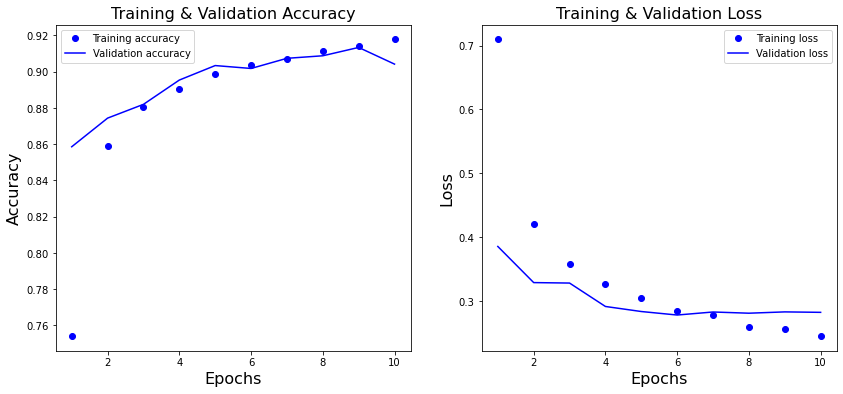

In [59]:
import matplotlib.pyplot as plt
  
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']
  
epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
#
# Plot the model accuracy vs Epochs
#
ax[0].plot(epochs, accuracy, 'bo', label='Training accuracy')
ax[0].plot(epochs, val_accuracy, 'b', label='Validation accuracy')
ax[0].set_title('Training & Validation Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend()
#
# Plot the loss vs Epochs
#
ax[1].plot(epochs, loss_values, 'bo', label='Training loss') 
ax[1].plot(epochs, val_loss_values, 'b', label='Validation loss')
ax[1].set_title('Training & Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()


---

With image data one of the cool things that we can do is to visualize what the kernel in a given convolutional layer is actually doing.

[GTR: However, I can't remember where I got this from and I can't get the last cell to work because I don't have the code for the "convolution" function.]

In [60]:
conv1 = model.layers[0]
weights1 = conv1.get_weights()
len(weights1)

2

In [61]:
kernels1 = weights1[0]
kernels1.shape

kernels1_1 = kernels1[:,:,0,0]
kernels1_1.shape

(7, 7)

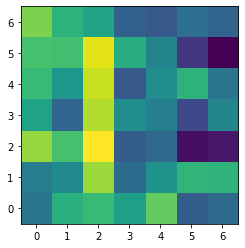

In [62]:
plt.imshow(kernels1_1)

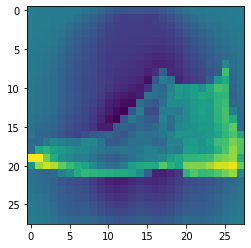

In [63]:
test_image = X_test[0, :, :, 0]
plt.imshow(test_image, origin='upper')

---

---

## Autoencoders  <a class="anchor" id="four"></a>

Autoencoders are neural networks that copy their input to their output, but after passing the data through a bottleneck.  For example if there are 28x28 = 784 inputs, there will also be 784 outputs, but there will be one or more (odd, but symmetric) hidden layers with fewer neuron than that.

For example see 

![autoencoder structure](https://miro.medium.com/max/1400/1*44eDEuZBEsmG_TCAKRI3Kw@2x.png)

from
https://towardsdatascience.com/applied-deep-learning-part-3-autoencoders-1c083af4d798

So, distill our MNIST digits down to the three most important pixels.  Or perhaps the three most important line segments.

You can think of this as doing PCA with a neural network -- breaking our data down into the only the most important features that we actually *need* (finding the intrinsic dimensionality).   In fact, if the network uses only linear (or no) activation functions and $l2$ cost function, then we have exactly PCA.

How might this be useful?  Well, for example we can use it to reconstruct MNIST digits that have had noise added to them:

![autoencoder example](https://miro.medium.com/max/1400/1*SxwRp9i23OM0Up4sEze1QQ@2x.png)

More exciting possibilities are: 

- Using autoencoders for "**unsupervised pretraining**". For example you have data that is only partially labeled (at least not enough to do traditional supervised classification).  We can train an autoencoder on the full data set, then used the encoder part as the base of a regular neural network that is trained on the labeled data that we do have. This is found to be a much more efficient way of initializing weights and biases than starting from random, because you are "cheating" a bit by already figuring out some of the data structure using the autoencoder. See Geron Figure 17.6.
- **[Anomaly detection](https://scikit-learn.org/stable/modules/outlier_detection.html)**, e.g. https://towardsdatascience.com/anomaly-detection-with-autoencoder-b4cdce4866a6 and https://towardsdatascience.com/anomaly-detection-using-autoencoders-5b032178a1ea. See also
https://www.pyimagesearch.com/2020/03/02/anomaly-detection-with-keras-tensorflow-and-deep-learning/ and 
https://towardsdatascience.com/autoencoder-neural-network-for-anomaly-detection-with-unlabeled-dataset-af9051a048.

### Autoencoder Example

Let's build a stacked Autoencoder with 3 hidden layers and 1 output layer (i.e., 2 stacked Autoencoders) and run it on the fashion MNIST data set.

See
https://github.com/ageron/handson-ml2/blob/master/17_autoencoders_and_gans.ipynb

Specifically, we are going to build this:

[Geron17-3autoencoder.png](attachment:Geron17-3autoencoder.png)

In [64]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [65]:
tf.random.set_seed(42)
np.random.seed(42)

stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu"),
])
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="binary_crossentropy",
                   optimizer=keras.optimizers.SGD(lr=1.5), metrics=['accuracy'])
history = stacked_ae.fit(X_train, X_train, epochs=20,
                         validation_data=(X_valid, X_valid))

Epoch 1/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3381 - accuracy: 0.0831 - val_loss: 0.3173 - val_accuracy: 0.0977
Epoch 2/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3056 - accuracy: 0.1032 - val_loss: 0.3020 - val_accuracy: 0.1087
Epoch 3/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2986 - accuracy: 0.1171 - val_loss: 0.2986 - val_accuracy: 0.1230
Epoch 4/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2948 - accuracy: 0.1245 - val_loss: 0.2938 - val_accuracy: 0.1271
Epoch 5/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2923 - accuracy: 0.1294 - val_loss: 0.2919 - val_accuracy: 0.1301
Epoch 6/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2904 - accuracy: 0.1347 - val_loss: 0.2914 - val_accuracy: 0.1308
Epoch 7/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2890 - accuracy: 0.1387 - val_loss: 0.2906 - val_accuracy:

Let's look at the output reconstructions.

In [66]:
#Helper function from Geron to show example reconstructions
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plt.imshow(images[image_index], cmap="binary", origin='upper')
        plt.axis("off")  
        
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plt.imshow(reconstructions[image_index], cmap="binary", origin='upper')
        plt.axis("off")                 

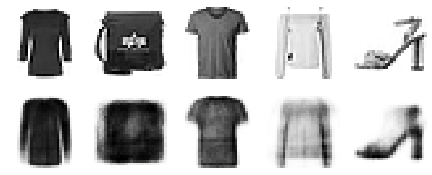

In [67]:
show_reconstructions(stacked_ae)

Now we can use t-SNE to visualize the clustering

In [68]:
np.random.seed(42)

from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

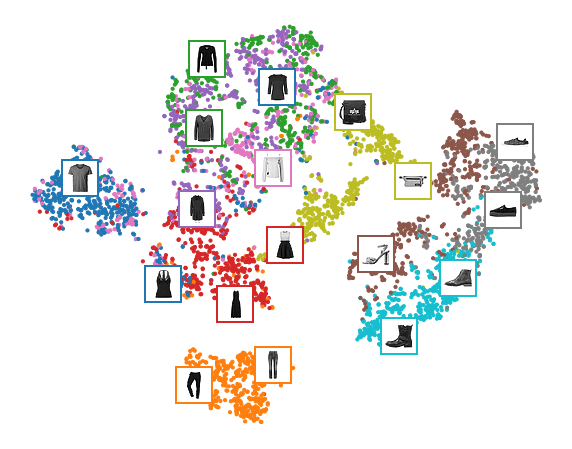

In [69]:
# From Geron
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary", origin='upper'),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

---

## Variational Autoencoders  <a class="anchor" id="five"></a>

More common in astronomy are variational autoencoders, partly because the "latent space" that results from a standard autoencoder doesn't necessarily map continuously to the data (e.g., if your training data don't span the full data space).  We won't go into detail, just realize that these are something that you might try if you were otherwise going to try an autoencoder to tackle your problem.

 **Instead of the encoder layers compressing the data down to a single point in the "latent space", it is mapped to a continuous distribution** (imagine if PCA gave you a probabilistic compression). The prior on this continuous distribution is a Gaussian with mean and variance. ***Therefore the intuition for variational autoencoders is that the mean vector centers the average encoding of the data point, while the variance samples around this average encoding.*** This allows the encoding and decoding to interpolate much more smoothly across the training data. 
 
![Ivezic Figure 9.21](https://www.astroml.org/_images/fig_vae_1.png)

[Geron17-12variational_autoencoder.png](attachment:Geron17-12variational_autoencoder.png)

#### Vanderbilt Variational Autoencoder Example

Let's build a variational autoencoder and train it on a sample of SDSS spectra. We'll switch back to `pytorch`. Grab the data, normalize and prepare for the network, then do a 3:1 train-test split.

In [ ]:
from astroML.datasets import sdss_corrected_spectra
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

# Fetch and prepare the data
data = sdss_corrected_spectra.fetch_sdss_corrected_spectra()
spectra = sdss_corrected_spectra.reconstruct_spectra(data)
wavelengths = sdss_corrected_spectra.compute_wavelengths(data)

# normalize spectra by integrated flux and subtract out mean, for easier training
spectranorms = np.mean(spectra, axis=1)
normedspectra = spectra / spectranorms[:, None]
meanspectrum = np.mean(normedspectra, axis=0)
normedspectra -= meanspectrum[None, :]

# split data into 3:1 train:test
torch.manual_seed(802)  # seed used for book figure
dataset = torchdata.TensorDataset(torch.tensor(normedspectra))
trainnum = normedspectra.shape[0] // 4 * 3
traindata, testdata = torchdata.random_split(dataset, 
                                             [trainnum, normedspectra.shape[0] - trainnum])
traindataloader = torchdata.DataLoader(traindata, batch_size=128, shuffle=True)

Now define the structure of the variational autoencoder. 
- In the top block you can see that the first layer reduces the $1000$-D input down to $250$.
- We then pass to a $2$D mean and variance layer from which the compressed "latent" parameters can be probabilistically drawn. This means that we compressing down from a 1000 flux channels to a 2D compressed representation.
- The decoding layers decompress the sampled latent parameters and scale back up to the full 1000 flux channel dimensions.

In [ ]:
# define structure of variation autoencoder
class VAE(nn.Module):
    def __init__(self, nhidden=250):
        super(VAE, self).__init__()

        # encoding layers
        self.encode_fc = nn.Linear(1000, nhidden)
        self.mu        = nn.Linear(nhidden, 2)
        self.logvar    = nn.Linear(nhidden, 2)

        # decoding layers
        self.decode_fc = nn.Linear(2, nhidden)
        self.output    = nn.Linear(nhidden, 1000)

    def encode(self, x):
        h = F.relu(self.encode_fc(x))
        return self.mu(h), self.logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        h = F.relu(self.decode_fc(z))
        return self.output(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

The loss is a modified version of the usual MSE, where we use the **Kullback-Leibler divergence** to asses how close the latent parameter distribution is to a Gaussian. 

In [ ]:
# add KL divergence to loss function
def VAEloss(criterion, recon_x, x, mu, logvar):
    return criterion(recon_x, x) - 0.5 * torch.sum(1 + logvar - 
                                                   mu.pow(2) - 
                                                   logvar.exp())

Another large block that is essentially just training the network.

In [ ]:
def train_model():
    model = VAE()
    criterion = torch.nn.MSELoss(reduction='sum')
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                           verbose=True, 
                                                           patience=5, 
                                                           threshold=1e-3)

    min_valid_loss = float('inf')
    badepochs = 0
    for t in range(1000):
        train_loss = 0
        for i, databatch in enumerate(traindataloader, 0):
            specbatch = databatch[0]
            optimizer.zero_grad()
            recon, mu, logvar = model(specbatch)
            loss = VAEloss(criterion, recon, 
                           specbatch, mu, logvar)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        with torch.no_grad():
            testspec = testdata[:][0]
            recon, mu, logvar = model(testspec)
            valid_loss = VAEloss(criterion, recon, 
                                 testspec, mu, logvar)
            if t % 10 == 0:
                print('Epoch %3i: train loss %6.1f validation loss %6.1f' % \
                        (t, train_loss / len(traindata), valid_loss / len(testdata)))
            # stop training if validation loss has not fallen in 10 epochs
            if valid_loss > min_valid_loss*(1-1e-3):
                badepochs += 1
            else:
                min_valid_loss = valid_loss
                badepochs = 0
            if badepochs == 10:
                print('Finished training')
                break
        scheduler.step(valid_loss)
    return model

In [ ]:
print(model)

Let's train this thing! (Takes less than a minute)

In [ ]:
model = train_model()

In [ ]:
# plot results
with torch.no_grad():
    # sort latent parameters from most constrained to least constrained
    testspec = dataset[:][0]
    recon, mu, logvar = model(testspec)
    zorder = np.argsort(np.mean(logvar.numpy(), axis=0))

    fig = plt.figure(figsize=(10, 6))
    fig.subplots_adjust(hspace=0, wspace=0)
    parvalues = [-2.,0.,2.]
    for i, z1 in enumerate(parvalues):
        for j, z2 in enumerate(parvalues):
            # get z1 to vary left to right, z2 bottom to top
            ax = fig.add_subplot(3, 3, (2-j)*len(parvalues)+i+1)

            z = np.zeros((1,2), dtype=np.float32)
            z[0, zorder] = z1, z2 # set z1 is more constrained of the two latent parameters
            spectrum = model.decode(torch.tensor(z))
            ax.plot(wavelengths, meanspectrum+spectrum.numpy()[0,:])
            ax.text(6750, 3, '(%i, %i)' % (z1,z2))

            ax.set_xlim(3000, 8000)
            ax.set_ylim(-1, 4)

            if i == 0 and j == 1:
                ax.set_ylabel('flux')
            else:
                ax.yaxis.set_major_formatter(plt.NullFormatter())
            if j == 0 and i == 1:
                ax.set_xlabel(r'${\rm wavelength\ (\AA)}$')
            else:
                ax.xaxis.set_major_formatter(plt.NullFormatter())
plt.show()

The spectra above are generated from our variational autoencoder. As mentioned, the encoder was limited to two components (2D compressed latent space). As neurons are progressively activated in the latent space, we generate a smooth transition from spectra consistent with quiscent to star-forming galaxies. The numbers in each panel indicate the activation value of the two neurons in the latent space.

#### GTR Variational Autoencoder Example

Until GANs (see below), this is how you would have generated fake images.

In [70]:
K = keras.backend

class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean

In [71]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 10

inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)
variational_ae.add_loss(K.mean(latent_loss) / 784.)
variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=['accuracy'])
history = variational_ae.fit(X_train, X_train, epochs=20, batch_size=128,
                             validation_data=(X_valid, X_valid))

Epoch 1/20
430/430 [==============================] - 3s 7ms/step - loss: 0.3894 - accuracy: 0.0750 - val_loss: 0.3688 - val_accuracy: 0.0838
Epoch 2/20
430/430 [==============================] - 3s 8ms/step - loss: 0.3427 - accuracy: 0.0930 - val_loss: 0.3358 - val_accuracy: 0.0905
Epoch 3/20
430/430 [==============================] - 3s 7ms/step - loss: 0.3327 - accuracy: 0.1008 - val_loss: 0.3321 - val_accuracy: 0.0985
Epoch 4/20
430/430 [==============================] - 3s 7ms/step - loss: 0.3279 - accuracy: 0.1084 - val_loss: 0.3278 - val_accuracy: 0.1094
Epoch 5/20
430/430 [==============================] - 3s 7ms/step - loss: 0.3247 - accuracy: 0.1129 - val_loss: 0.3275 - val_accuracy: 0.1052
Epoch 6/20
430/430 [==============================] - 3s 7ms/step - loss: 0.3225 - accuracy: 0.1176 - val_loss: 0.3246 - val_accuracy: 0.1224
Epoch 7/20
430/430 [==============================] - 3s 7ms/step - loss: 0.3209 - accuracy: 0.1221 - val_loss: 0.3224 - val_accuracy: 0.1272
Epoch 

Now generate some fake images.  Note that the goal here is NOT to teach you how to create "deep fakes", but rather to build up to scientifically useful applications of GANs.

In [72]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary", origin='upper')
        plt.axis("off")

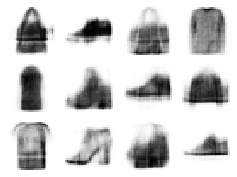

In [73]:
tf.random.set_seed(42)

codings = tf.random.normal(shape=[12, codings_size])
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)

---

## Generative Adversarial Networks (GANs)  <a class="anchor" id="six"></a>

GANs are pure evil, see
https://thispersondoesnotexist.com.  The picture you see is not a real person-- it was generated by a neural network.

But they are also brilliant, incredibly useful, and relatively new (2014).  The idea builds logically on autoencoders.

1. We have a generator (like the decoder part of an autoencoder) that can produce fake data (e.g., an image). 
2. Then we have a discriminator (a standard binary classifier) that tries to distinguish fake data from real.  
3. Then the generator learns to produce more and more accurate images to trick the discriminator -- without ever seeing any real images -- it just has the feedback from the discriminator.
4. We are pitting artifical neural networks against themselves to make them stronger. What could possibly go wrong, right?

![](https://learning.oreilly.com/library/view/java-deep-learning/9781788997454/assets/2cf8b4f1-7163-4af1-aa4b-6066329d554a.png)


[Geron17-15GAN.png](attachment:Geron17-15GAN.png)

[Geron17-18GANexample.png](attachment:Geron17-18GANexample.png)

For more, see
https://towardsdatascience.com/understanding-generative-adversarial-networks-gans-cd6e4651a29

Astronomy has seen some interesting uses of autoencoders and GANs in recent years.  For example:
    
- https://arxiv.org/abs/1702.00403    
- https://www.aanda.org/articles/aa/full_html/2017/07/aa30240-16/aa30240-16.html
- https://arxiv.org/pdf/1711.03121.pdf
- https://arxiv.org/pdf/1812.02183.pdf

### Generative Adversarial Network (GAN) example

In [74]:
np.random.seed(42)
tf.random.set_seed(42)

codings_size = 30

generator = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[codings_size]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
discriminator = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])

In [75]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [76]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [77]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))              # not shown in the book
        for X_batch in dataset:
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
        plot_multiple_images(generated_images, 8)                     # not shown
        plt.show()         

Epoch 1/1


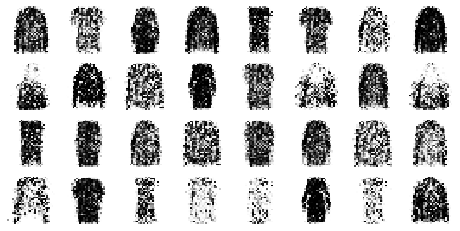

In [78]:
train_gan(gan, dataset, batch_size, codings_size, n_epochs=1)

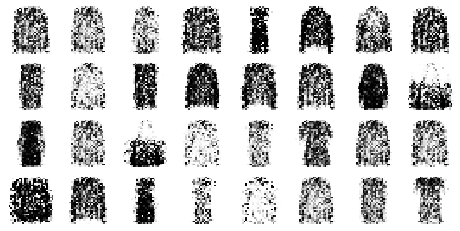

In [79]:
tf.random.set_seed(42)
np.random.seed(42)

noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator(noise)
plot_multiple_images(generated_images, 8)

Geron then runs the GAN for 50 epochs and discusses why training GANs is so hard and is still an active area of research.

---

---

More exciting to me is the possibility to use autoencoders for "unsupervised pretraining".  For example you have data that is only partially labeled (at least not enough to do traditional supervised classification).  We can train an autoencoder on the full data set, then used the encoder part as the base of a regular neural network that is trained on the labeled data that we do have.  See Geron Figure 17.6

Also for [anomaly detection](https://scikit-learn.org/stable/modules/outlier_detection.html).
See also
https://www.pyimagesearch.com/2020/03/02/anomaly-detection-with-keras-tensorflow-and-deep-learning/ and 
https://towardsdatascience.com/autoencoder-neural-network-for-anomaly-detection-with-unlabeled-dataset-af9051a048.

The last example will pretend that we have a very large training set, but with only a small fraction of the training set having labels.  So, we will use tranfer learning from a pre-trained autoencoder that "clusters" all of the unlabeled training data to build the base layers of a our classification neural network.

[Geron17-6transferlearning.png](attachment:Geron17-6transferlearning.png)

[Geron](./figures/Geron17-6transferlearning.png)

This is exactly the problem that we have for quasar selection in LSST.  We have about 500k quasars that are labeled (plus labels for stars and galaxies) but those objects don't necessarily represent the full range of objects that we are trying to find.  So, it might help to use this pre-training technique.

We'll do this with Fashion MNIST data set as above.  Let's train the autoencoder with 2/3 of the full training set data (but without the labels!), which is 40k objects.  Then we'll have 10k for the test set, the validation set, and our "B" training set.  Then we'll see how that compares to a regular neural net trained with only the "B" training data.

See 
https://github.com/ageron/handson-ml2/blob/master/11_training_deep_neural_networks.ipynb
and
https://github.com/ageron/handson-ml2/blob/master/17_autoencoders_and_gans.ipynb

In [80]:
keras.backend.clear_session() #Make sure that we are starting a new model and not adding to an earlier one
np.random.seed(42) #Set the numpy and tensorflow random seeds so that we all get the same answer
tf.random.set_seed(42)

In [81]:
#We'll use 60% of the sample to do unsupervised training with an autoencoder
#Then 10% each for supervised training, validation, and testing
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
print(len(X_train_full),len(X_test))

60000 10000


In [82]:
from sklearn.model_selection import train_test_split

X_train_A, X_rest, y_train_A, y_rest = train_test_split(X_train_full, y_train_full, test_size=0.33333, random_state=42)
print(len(X_train_A),len(X_rest))

X_train_B, X_valid, y_train_B, y_valid = train_test_split(X_rest, y_rest, test_size=0.50, random_state=42)
print(len(X_train_B),len(X_valid))

40000 20000
10000 10000


In [83]:
stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(200, activation="selu"),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu"),
])
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(200, activation="selu", input_shape=[100]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="binary_crossentropy",
                   optimizer=keras.optimizers.SGD(lr=1.5), metrics=['accuracy'])
history = stacked_ae.fit(X_train_A, X_train_A, epochs=50,
                         validation_data=(X_valid, X_valid))

Epoch 1/50
1250/1250 [==============================] - 3s 2ms/step - loss: 0.3401 - accuracy: 0.0839 - val_loss: 0.3091 - val_accuracy: 0.0961
Epoch 2/50
1250/1250 [==============================] - 2s 2ms/step - loss: 0.3056 - accuracy: 0.1045 - val_loss: 0.3185 - val_accuracy: 0.1054
Epoch 3/50
1250/1250 [==============================] - 3s 2ms/step - loss: 0.2981 - accuracy: 0.1188 - val_loss: 0.2968 - val_accuracy: 0.1240
Epoch 4/50
1250/1250 [==============================] - 3s 2ms/step - loss: 0.2938 - accuracy: 0.1294 - val_loss: 0.2916 - val_accuracy: 0.1371
Epoch 5/50
1250/1250 [==============================] - 3s 2ms/step - loss: 0.2906 - accuracy: 0.1380 - val_loss: 0.2889 - val_accuracy: 0.1404
Epoch 6/50
1250/1250 [==============================] - 3s 2ms/step - loss: 0.2885 - accuracy: 0.1436 - val_loss: 0.2873 - val_accuracy: 0.1473
Epoch 7/50
1250/1250 [==============================] - 3s 2ms/step - loss: 0.2866 - accuracy: 0.1487 - val_loss: 0.2869 - val_accuracy:

In [84]:
stacked_encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 200)               157000    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_2 (Dense)              (None, 30)                3030      
Total params: 180,130
Trainable params: 180,130
Non-trainable params: 0
_________________________________________________________________


In [85]:
stacked_decoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 100)               3100      
_________________________________________________________________
dense_4 (Dense)              (None, 200)               20200     
_________________________________________________________________
dense_5 (Dense)              (None, 784)               157584    
_________________________________________________________________
reshape (Reshape)            (None, 28, 28)            0         
Total params: 180,884
Trainable params: 180,884
Non-trainable params: 0
_________________________________________________________________


In [86]:
stacked_ae.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 30)                180130    
_________________________________________________________________
sequential_1 (Sequential)    (None, 28, 28)            180884    
Total params: 361,014
Trainable params: 361,014
Non-trainable params: 0
_________________________________________________________________


In [87]:
stacked_ae.save("autoencoder.h5")

In [102]:
from sklearn.manifold import TSNE

#Maybe should be X_train_A if want to visualize clustering of autoencoder training results?
#But plot validation objects on top?
#X_valid_compressed = stacked_encoder.predict(X_valid)
X_valid_compressed = stacked_encoder.predict(X_train_A)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

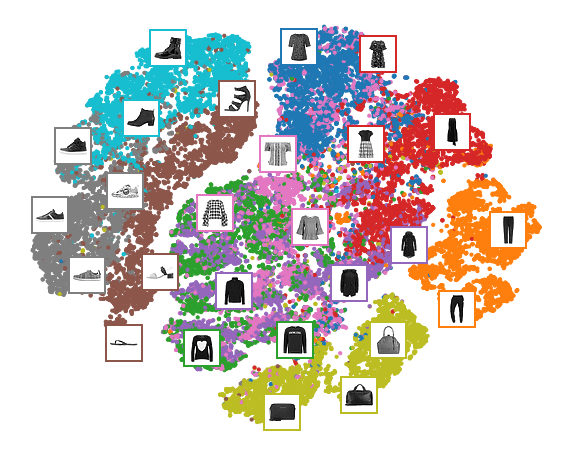

In [105]:
# From Geron
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
#plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap=cmap)
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_train_A, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            #mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary", origin='upper'),
            mpl.offsetbox.OffsetImage(X_train_A[index], cmap="binary", origin='upper'),
            #position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
            position, bboxprops={"edgecolor": cmap(y_train_A[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

In [90]:
model_A = keras.models.load_model("autoencoder.h5") #Read in full autoencoder model
#model_B_on_A = keras.models.Sequential(model_A.layers[:-1]) #Just take the encoder part
#model_B_on_A.add(keras.layers.Dense(10, activation="softmax")) #Now add on a new ouput layer

In [106]:
#Need to clone model A and set weights otherwise they will be update when fitting model_B_on_A
model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

model_B_on_A = keras.models.Sequential(model_A_clone.layers[:-1]) #Just take the encoder part
model_B_on_A.add(keras.layers.Dense(10, activation="softmax")) #Now add on a new ouput layer

#Freeze reused layers during first few epochs
#Later will have to unfreeze
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

In [107]:
#Now need to compile
model_B_on_A.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [108]:
#Run for a few epochs
#Here we need the answers; don't use data that trained autoencoder.
#Might not be OK to use test data for validation here?
history2 = model_B_on_A.fit(X_train_B, y_train_B, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
313/313 [==============================] - 1s 2ms/step - loss: 1.0842 - accuracy: 0.6516 - val_loss: 0.7030 - val_accuracy: 0.7486
Epoch 2/10
313/313 [==============================] - 0s 1ms/step - loss: 0.5616 - accuracy: 0.7925 - val_loss: 0.5590 - val_accuracy: 0.7971
Epoch 3/10
313/313 [==============================] - 0s 1ms/step - loss: 0.4931 - accuracy: 0.8218 - val_loss: 0.5285 - val_accuracy: 0.8111
Epoch 4/10
313/313 [==============================] - 0s 1ms/step - loss: 0.4596 - accuracy: 0.8349 - val_loss: 0.5022 - val_accuracy: 0.8171
Epoch 5/10
313/313 [==============================] - 0s 1ms/step - loss: 0.4401 - accuracy: 0.8427 - val_loss: 0.4769 - val_accuracy: 0.8307
Epoch 6/10
313/313 [==============================] - 0s 2ms/step - loss: 0.4267 - accuracy: 0.8474 - val_loss: 0.4700 - val_accuracy: 0.8306
Epoch 7/10
313/313 [==============================] - 0s 2ms/step - loss: 0.4175 - accuracy: 0.8519 - val_loss: 0.4615 - val_accuracy: 0.8373
Epoch 

In [109]:
#Unfreeze reused layers
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

In [110]:
#Recompile with lower learning rate
#Keep fitting for more epochs
model_B_on_A.compile(loss="sparse_categorical_crossentropy",
                     optimizer=keras.optimizers.SGD(lr=1e-3),
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=40,
                           validation_data=(X_valid, y_valid))

Epoch 1/40
313/313 [==============================] - 1s 2ms/step - loss: 0.3920 - accuracy: 0.8614 - val_loss: 0.4381 - val_accuracy: 0.8446
Epoch 2/40
313/313 [==============================] - 1s 2ms/step - loss: 0.3885 - accuracy: 0.8628 - val_loss: 0.4355 - val_accuracy: 0.8450
Epoch 3/40
313/313 [==============================] - 0s 2ms/step - loss: 0.3863 - accuracy: 0.8649 - val_loss: 0.4364 - val_accuracy: 0.8460
Epoch 4/40
313/313 [==============================] - 1s 2ms/step - loss: 0.3837 - accuracy: 0.8641 - val_loss: 0.4328 - val_accuracy: 0.8459
Epoch 5/40
313/313 [==============================] - 1s 2ms/step - loss: 0.3814 - accuracy: 0.8658 - val_loss: 0.4314 - val_accuracy: 0.8463
Epoch 6/40
313/313 [==============================] - 1s 2ms/step - loss: 0.3792 - accuracy: 0.8672 - val_loss: 0.4300 - val_accuracy: 0.8477
Epoch 7/40
313/313 [==============================] - 1s 2ms/step - loss: 0.3773 - accuracy: 0.8682 - val_loss: 0.4288 - val_accuracy: 0.8474
Epoch 

In [112]:
model_B_on_A.save("autoencoder_transfer_example.h5")

In [113]:
model_B_on_A.evaluate(X_test, y_test)

313/313 [==============================] - 0s 745us/step - loss: 0.4291 - accuracy: 0.8484


[0.42913833260536194, 0.8483999967575073]

In [114]:
model_B = keras.models.Sequential() #Instantiate a sequential model
model_B.add(keras.layers.Flatten(input_shape=[28, 28])) #Define the input layer
model_B.add(keras.layers.Dense(300, activation="relu")) #First hidden layer
model_B.add(keras.layers.Dense(100, activation="relu")) #Second hidden layer
model_B.add(keras.layers.Dense(10, activation="softmax")) #Output layer

In [115]:
#Now need to compile
model_B.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [116]:
history_B = model_B.fit(X_train_B, y_train_B, epochs=50,
                           validation_data=(X_valid, y_valid))

Epoch 1/50
313/313 [==============================] - 1s 2ms/step - loss: 1.2571 - accuracy: 0.6320 - val_loss: 0.9271 - val_accuracy: 0.6648
Epoch 2/50
313/313 [==============================] - 1s 2ms/step - loss: 0.7307 - accuracy: 0.7641 - val_loss: 0.6818 - val_accuracy: 0.7854
Epoch 3/50
313/313 [==============================] - 1s 2ms/step - loss: 0.6212 - accuracy: 0.7971 - val_loss: 0.6611 - val_accuracy: 0.7721
Epoch 4/50
313/313 [==============================] - 1s 2ms/step - loss: 0.5623 - accuracy: 0.8160 - val_loss: 0.6761 - val_accuracy: 0.7440
Epoch 5/50
313/313 [==============================] - 1s 2ms/step - loss: 0.5276 - accuracy: 0.8268 - val_loss: 0.5476 - val_accuracy: 0.8104
Epoch 6/50
313/313 [==============================] - 1s 2ms/step - loss: 0.5038 - accuracy: 0.8284 - val_loss: 0.5194 - val_accuracy: 0.8192
Epoch 7/50
313/313 [==============================] - 1s 2ms/step - loss: 0.4830 - accuracy: 0.8393 - val_loss: 0.5202 - val_accuracy: 0.8205
Epoch 

In [117]:
model_B.evaluate(X_test, y_test)

313/313 [==============================] - 0s 809us/step - loss: 0.4487 - accuracy: 0.8508


[0.4486900866031647, 0.8507999777793884]

We find that Model B is actually better than Model A on B.  Geron says that this shouldn't be expected to work well with a small dense network.  Need a deeper network (maybe even CNN) to get best reslts.  But this at least shows how it is done.

It is worth noting that we **do** have the answers for the full training set here, but if you did **NOT** then the 84.8% that we got (compared to 85.1%) is pretty darn good!

---

* Sigmoid needed for output of binary classification (with binary cross entropy loss)
* ReLU for layers other than output
* Softmax for output with more than 2 classes (with categorical cross entropy loss)

multi-label is like doing several binary classifications at once, so use sigmoid activation function.

One vs. rest

Train faster with mini-batches.  Updates weights N mini-batches times per epoch.
Batches normalize between layers.

Current version leaves no place for AdaBoost or LogisticRegression.